In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import spline

In [17]:
class MultiBandit():
    """
    UCB: Upper-Confidence-bound Action Selection
    c: this controls the degree of exploration in UCB
    """
    def __init__(self, K_arms=10, initial_value=0, step_size=0.1, 
                 epsilon=0, trueReward=0, sampleAverage=False, UCB=False, c=2, gradient=False, gradientBaseline=False):
        self.K_arms = K_arms
        self.initial_value = initial_value
        self.step_size = step_size
        self.epsilon = epsilon
        self.time = 0
        
        
        self.q_true = np.zeros(K_arms)
        self.q_estimated = np.zeros(K_arms)
        self.action_count = np.zeros(K_arms)
        self.averageReward = 0
        self.UCB = UCB
        self.c = c
        self.gradient = gradient
        self.gradientBaseline = gradientBaseline
        
        self.sampleAverage = sampleAverage
        
        for i in range(K_arms):
            self.q_true[i] = np.random.randn() + trueReward
            self.q_estimated[i] = initial_value
            
        self.best_action = np.argmax(self.q_true)
        
    
    def getAction(self):
        if self.epsilon > 0:
            if np.random.binomial(1, self.epsilon) == 1:
                return np.random.choice(np.arange(self.K_arms))
            
        if self.UCB:
            return np.argmax(self.q_estimated + self.c * np.sqrt(np.log(self.time)/self.action_count))
        
        if self.gradient:
            self.actionP = np.exp(self.q_estimated)/np.sum(np.exp(self.q_estimated))
            return np.random.choice(np.arange(self.K_arms), p=self.actionP)
        return np.argmax(self.q_estimated)
    
    def takeAction(self, action):
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.averageReward = (self.time - 1.0) / self.time * self.averageReward + reward / self.time
        if self.sampleAverage:
            self.q_estimated[action] += (1.0/self.action_count[action])*(reward - self.q_estimated[action])
        elif self.gradient:
            one_hot = np.zeros(self.K_arms)
            one_hot[action]=1
            if self.gradientBaseline:
                baseline = self.averageReward
            else:
                baseline = 0            
            self.q_estimated = self.q_estimated + self.step_size * (reward - baseline) * (one_hot - self.actionP)
        else:
            self.q_estimated[action] += self.step_size * (reward - self.q_estimated[action])
        return reward
        
        
        

## Reward Distribution

Text(0,0.5,'Reward distribution')

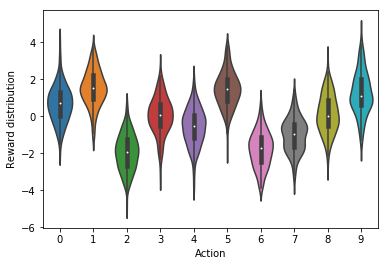

In [3]:
    plt.figure(0)
    sns.violinplot(data=np.random.randn(200,10) + np.random.randn(10))
    plt.xlabel("Action")
    plt.ylabel("Reward distribution")

## Bandit Simulator function

In [4]:
def banditSimulator(nBandits, steps, bandits):
    bestActionCounts =  [np.zeros(steps, dtype='float') for _ in range(len(bandits))]
    averageRewards = [np.zeros(steps, dtype='float') for _ in range(len(bandits))]
    for idx, bandit in enumerate(bandits):
        for i in range(0, nBandits):
            for j in range(0, steps):
                action = bandit[i].getAction()
                reward = bandit[i].takeAction(action)
                averageRewards[idx][j] += reward
                if action == bandit[i].best_action:
                    bestActionCounts[idx][j] += 1
        bestActionCounts[idx] /= nBandits
        averageRewards[idx] /= nBandits
    return bestActionCounts, averageRewards


# ε-Bandit

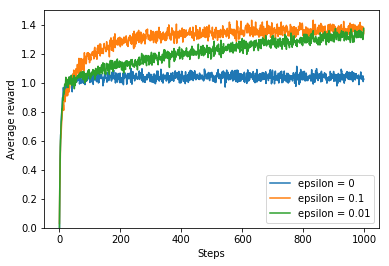

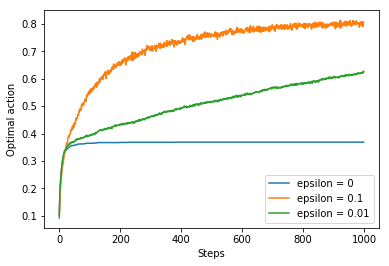

In [6]:
nBandits = 2000  # number of independent run
steps = 1000
epsilon = [0, 0.1, 0.01]
bandits = []
for eps in epsilon:
    bandits.append([MultiBandit(epsilon=eps, sampleAverage=True) for _ in range(nBandits)])

bestActionCounts, averageRewards = banditSimulator(nBandits, steps, bandits)

plt.figure(1)
for eps, rewards in zip(epsilon, averageRewards):
    plt.plot(rewards, label='epsilon = '+str(eps))
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.ylim([0, 1.5])
plt.legend()

plt.figure(2)
for eps, counts in zip(epsilon, bestActionCounts):
    plt.plot(counts, label='epsilon = '+str(eps))
plt.xlabel('Steps')
plt.ylabel('Optimal action')
plt.legend()


## Optimistic Initial Values

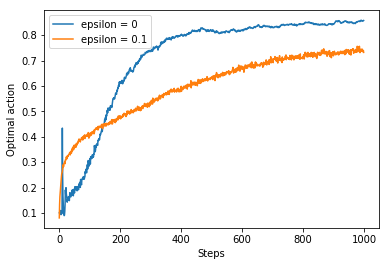

In [9]:
nBandits = 2000  # number of independent run
steps = 1000
bandits = []
bandits.append([MultiBandit(epsilon=0, initial_value=5) for _ in range(nBandits)])
bandits.append([MultiBandit(epsilon=0.1, initial_value=0) for _ in range(nBandits)])

bestActionCounts, averageRewards = banditSimulator(nBandits, steps, bandits)

plt.figure(3)
for eps, counts in zip(epsilon, bestActionCounts):
    plt.plot(counts, label='epsilon = '+str(eps))
plt.xlabel('Steps')
plt.ylabel('Optimal action')
plt.legend()

plt.show()

## Upper-Confidence-Bound Action Selection

/Users/junyamada/.virtualenvs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
/Users/junyamada/.virtualenvs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt
/Users/junyamada/.virtualenvs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/Users/junyamada/.virtualenvs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


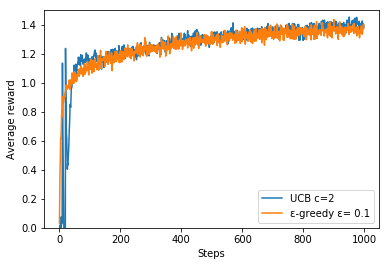

In [16]:
nBandits = 2000  # number of independent run
steps = 1000
bandits = []
bandits.append([MultiBandit(UCB=True, c=2) for _ in range(nBandits)])
bandits.append([MultiBandit(epsilon=0.1) for _ in range(nBandits)])

bestActionCounts, averageRewards = banditSimulator(nBandits, steps, bandits)

plt.figure(1)
plt.plot(averageRewards[0], label='UCB c=2')
plt.plot(averageRewards[1], label='ε-greedy ε= 0.1')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.ylim([0, 1.5])
plt.legend()

plt.show()

## Gradient Bandit Algorithms

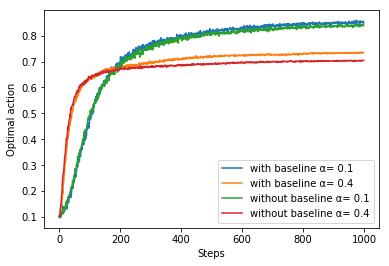

In [19]:
nBandits = 2000  # number of independent run
steps = 1000
bandits = []
bandits.append([MultiBandit(gradient=True, gradientBaseline=True, step_size=0.1) for _ in range(nBandits)])
bandits.append([MultiBandit(gradient=True, gradientBaseline=True, step_size=0.4) for _ in range(nBandits)])
bandits.append([MultiBandit(gradient=True, gradientBaseline=False, step_size=0.1) for _ in range(nBandits)])
bandits.append([MultiBandit(gradient=True, gradientBaseline=False, step_size=0.4) for _ in range(nBandits)])

bestActionCounts, averageRewards = banditSimulator(nBandits, steps, bandits)

plt.figure(3)
plt.plot(bestActionCounts[0], label='with baseline α= '+str(0.1))
plt.plot(bestActionCounts[1], label='with baseline α= '+str(0.4))
plt.plot(bestActionCounts[2], label='without baseline α= '+str(0.1))
plt.plot(bestActionCounts[3], label='without baseline α= '+str(0.4))
plt.xlabel('Steps')
plt.ylabel('Optimal action')
plt.legend()

plt.show()